# Internal Tide (only), 1 simulation

see link to [forcing description](../configs/itbalt/readme.ipynb)

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:43271,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:47588,Total threads: 7
Dashboard: http://127.0.0.1:47870/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:52471,


## Load data

In [3]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/slgentil/' 

#run = 'fsturb_t1_r1_a4_4km_0a50j' 
#run = 'fsturb_t1_r2_a4_4km_0a50j' 
run = 'fsturb_t1_r3_a4_4km_0a50j' 

r = pp.Run(root_path+run, outputs=["sec"], verbose=1)
r['sec'] = r['sec'].assign_coords(time=r['sec'].time_counter)

pout = r.params_output

Analysing directory /home1/scratch/slgentil/fsturb_t1_r3_a4_4km_0a50j
Found 1 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / sec
Grid size: (L ,M, N) = (18, 722, 50)


In [4]:
# specific to 2D run ...
def process_dim(da):
    rdict = {}
    for d, d_new in {"y_rhoy": "y_rho", "y_uy": "y_rho", "y_vy": "y_v"}.items(): 
        if d in da.dims:
            rdict[d] = d_new
    return da.rename(rdict)

ds = r["sec"].isel(x_rho=0)
for v in ds:
    ds[v] = process_dim(ds[v])

ds = ds.rename({v: v.replace("_yz", "") for v in ds})
ds = ds.drop(["x_rho", "x_rhoy", "x_uy", "x_vy", "y_rhoy", "y_uy", "y_vy"])

In [5]:
for k, v in pout.items():
    print('{}: {}'.format(k,v))

itide_omega: 0.0001454441043
itide_nmode: 2.0
forcing_itide: 1.0
h_itide: 2000.0
itide_Az: 0.002
itide_y: 1500000.0
itide_start_time: 0.0
tdiag_omega: 0.0001454441043
relax_dist_south: 1000000.0
relax_L_south: 350000.0
relax_tau_in_south: 1000.0
relax_tau_out_south: 1.0
relax_dist_north: 1000000.0
relax_L_north: 350000.0
relax_tau_in_north: 1000.0
relax_tau_out_north: 1.0
depth: 4000.0
f0: 0.00010313
beta: 0.0
yrbeta: 1440000.0
ini_flag: 1.0
ini_delta_rho: 0.001
ini_H_tcline: 0.15
ini_H_mld: 0.025
ini_H: 4000.0
flag_sponges: 1.0


---

## bulk statistics

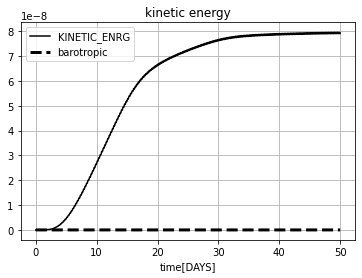

In [6]:
ax = r.stats['KINETIC_ENRG'].plot(color="k", title='kinetic energy')
#r.stats['KINETIC_ENRG'].plot(ax=ax, color='orange')
r.stats['BTKIN_ENRG'].plot(ax=ax, lw=3., color=ax.get_lines()[-1].get_color(), 
                           ls='--', label='barotropic')
ax.grid()
ax.legend()

---

## vertical slices

In [7]:
z_u = r.get_z(zeta=ds.ssh).isel(x_rho=0)
ds = ds.assign_coords(z_u = z_u)

In [8]:
time_slice = [5, 10, 40]

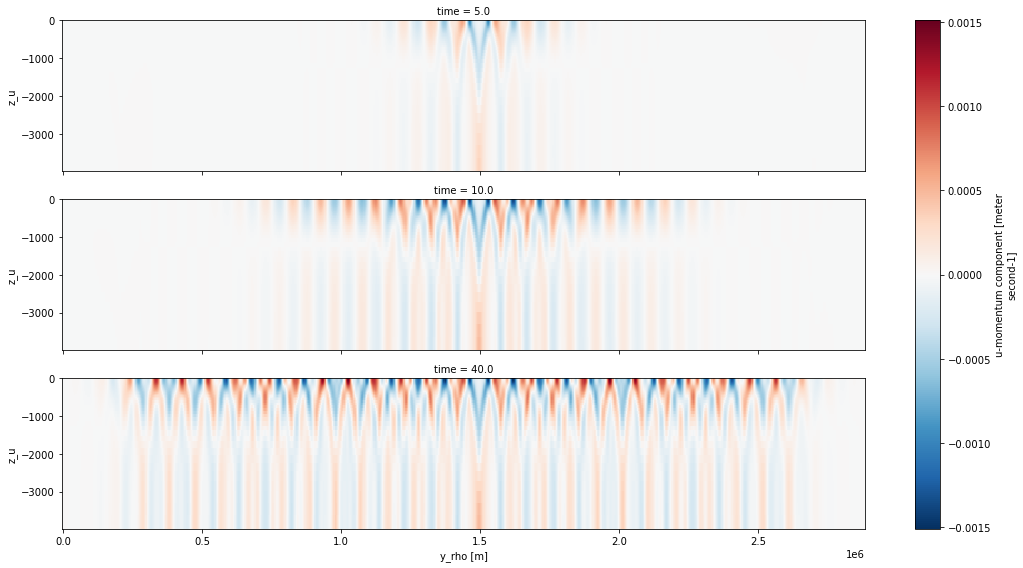

In [9]:
(ds.u
 .sel(time=time_slice)
 .plot(x='y_rho', y='z_u', 
       #xlim=(900*1e3,2000*1e3),
       figsize=(15,8),
       col='time', col_wrap=1)
)

---

## vertical mode projections

In [10]:
dsm = (ds
      .mean(dim=["time","y_rho"])
      .persist()
     )
rho = dsm['T']
ssh = dsm['ssh']

zm_r = r.get_z(zeta=ssh, h=ssh*0.+r['depth'])
zm_w = r.get_z(zeta=ssh, h=ssh*0.+r['depth'], vgrid='w')

N2 = r.get_N2(rho, zm_r)

In [11]:
vm = vmd.Vmodes(r['xgrid'], zm_r, zm_w, N2, 10,
                persist=True)

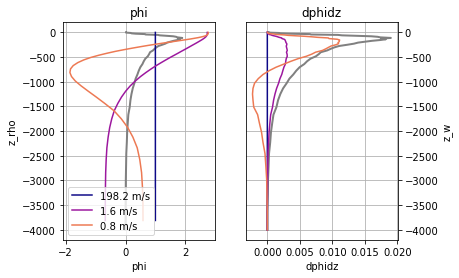

In [12]:
vm.plot()

## project

In [13]:
z_r = r.get_z(zeta=ds["ssh"], hgrid="r", vgrid="r").isel(x_rho=0)
z_w = r.get_z(zeta=ds["ssh"], hgrid="r", vgrid="w").isel(x_rho=0)
un = vm.project(ds["u"], "p", align=True, z=z_r)

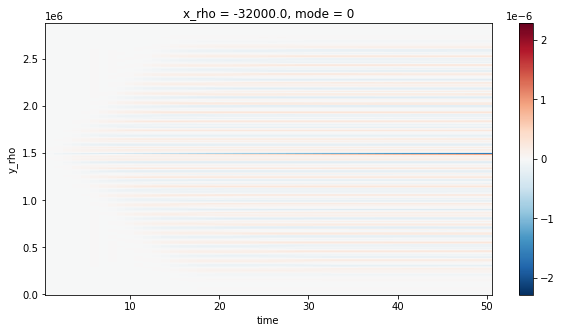

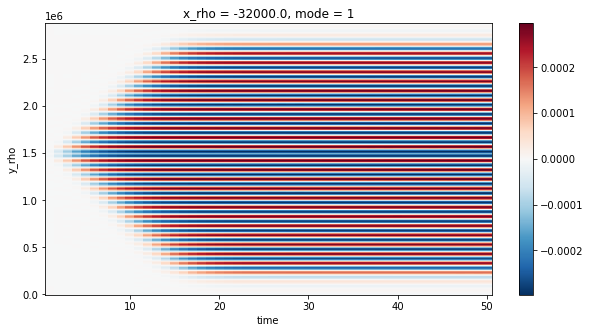

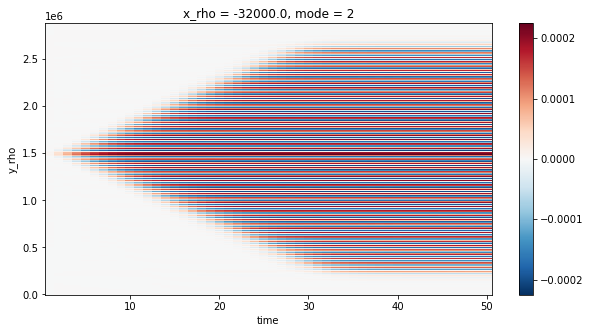

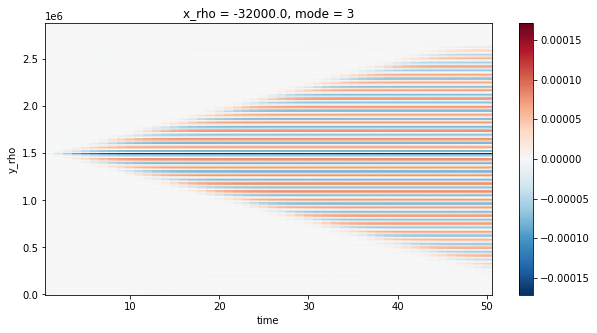

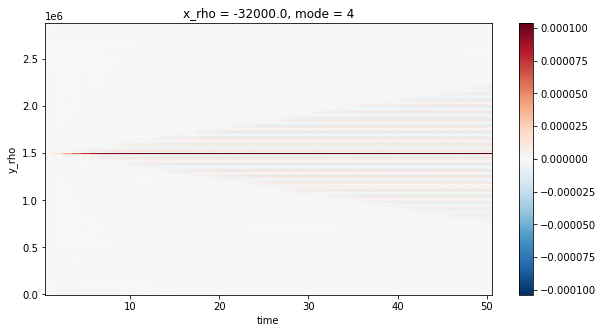

In [14]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    un.sel(mode=m).plot(ax=ax, x="time", y="y_rho")

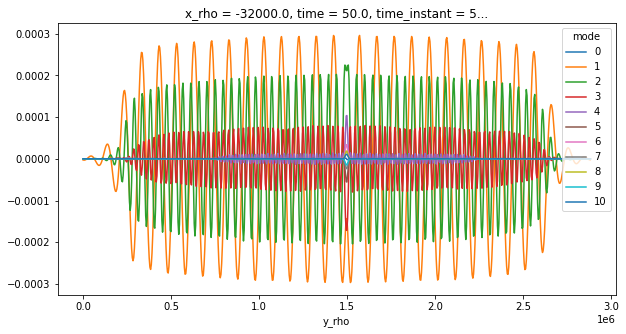

In [15]:
un.isel(time=-1).plot(x="y_rho", hue="mode", figsize=(10,5))

In [16]:
# compute pressure on rho grid
rho = ds["T"].rename('rho')
p = r.get_p(rho, z_w, zr=z_r)

# interpolates on mode vertical grid
p = op.interp2z(vm['z_rho'], z_r, p)
p_mean = p.mean("time")

# substract time and spatial average
p = p - p_mean

# project, data is already on vmode vertical grid
pn = vm.project(p, "p")
# abs(ds_depth['z_rho'] - vmodes['z_rho']).max().compute() # 0

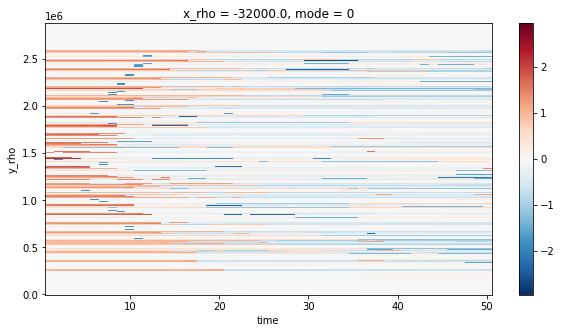

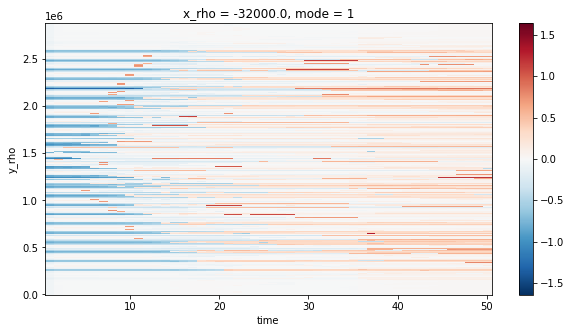

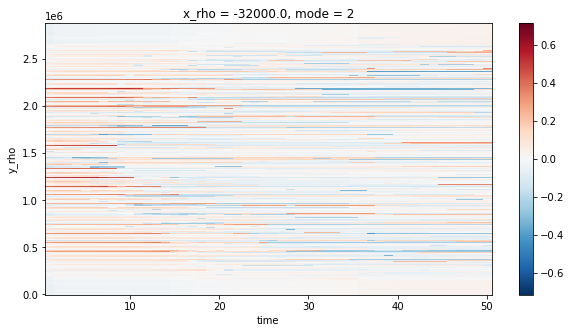

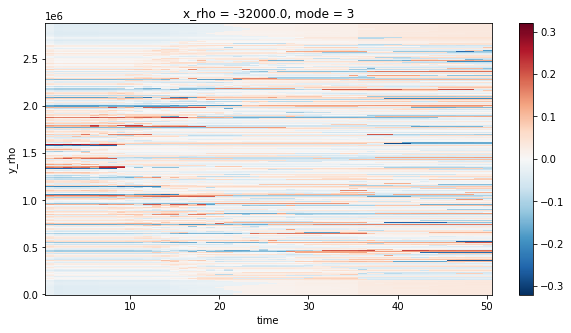

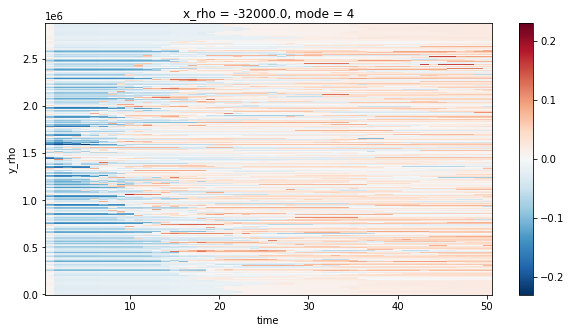

In [18]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    pn.sel(mode=m).plot(ax=ax, x="time", y="y_rho")

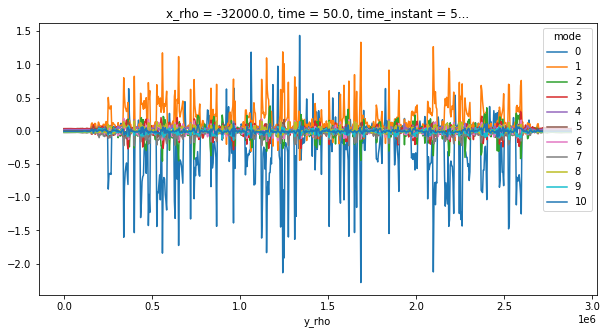

In [17]:
pn.isel(time=-1).plot(x="y_rho", hue="mode", figsize=(10,5))

---

In [ ]:
cluster.close()